In [27]:
from pathlib import Path
import os
import pandas as pd
import json
import matplotlib.pyplot as plt

In [5]:
path = "/mnt/c/github/explainabloomity/results"
models = ("opt-13b", )
prune_methods=(
    "balanced",
    # "imbalanced" ,
)
metrics=(
    "cosine_cosine" ,
    "euclidean_euclidean" ,
    "cosine_random",
    "euclidean_random",
)
prunetasks=(
    "paws_en",
    "hellaswag",
    "arc_easy",
    "blimp_ellipsis_n_bar_1",
)
prune_percents=(
    "0.25",
    "0.5",
    "0.75",
)
tasks=(
    "lambada_openai",
    "paws_en",
    "hellaswag",
    "arc_easy",
    "blimp_ellipsis_n_bar_1",
    "blimp_irregular_plural_subject_verb_agreement_1")

In [120]:
def get_results(path="/mnt/c/github/explainabloomity/results"):
    models = ("opt-13b", )
    prune_methods=(
        "balanced",
        # "imbalanced" ,
    )
    metrics=(
        "cosine_cosine" ,
        "euclidean_euclidean" ,
        "cosine_random",
        "euclidean_random",
    )
    prunetasks=(
        "paws_en",
        "hellaswag",
        "arc_easy",
        "blimp_ellipsis_n_bar_1",
    )
    prune_percents=(
        "0.25",
        "0.5",
        "0.75",
    )
    tasks=(
        "lambada_openai",
        "paws_en",
        "hellaswag",
        "arc_easy",
        "blimp_ellipsis_n_bar_1",
        "blimp_irregular_plural_subject_verb_agreement_1")
    rows = []
    for model in models:
        for prune_method in prune_methods:
            for prune_task in prunetasks:
                for prune_metric in metrics:
                    for task in tasks:
                        for prune_percent in prune_percents:
                            path_model = Path("./results")/ task / model / prune_method / prune_task / prune_metric / prune_percent / "results.json"
                            if path_model.exists():
                                with open(path_model, "r") as f:
                                    data = json.load(f)
                                    norm_accuracy = data["results"][task]["acc,none"]
                                    row = {"model": model, "prune_method": prune_method, "prune_task": prune_task, "metric": prune_metric, "percent": float(prune_percent), "task": task, "norm_accuracy": norm_accuracy}
                                    rows.append(row)
                        base_model = model + "_base"
                        path_model = Path("./results")/ task / base_model / "results.json"
                        if path_model.exists():
                            with open(path_model, "r") as f:
                                data = json.load(f)
                                norm_accuracy = data["results"][task]["acc,none"]
                                row = {"model": model, "prune_method": prune_method, "prune_task": prune_task, "metric": prune_metric, "percent": 0.0, "task": task, "norm_accuracy": norm_accuracy}
                                rows.append(row)


    df = pd.DataFrame(rows)
    return df

In [121]:
df = get_results()

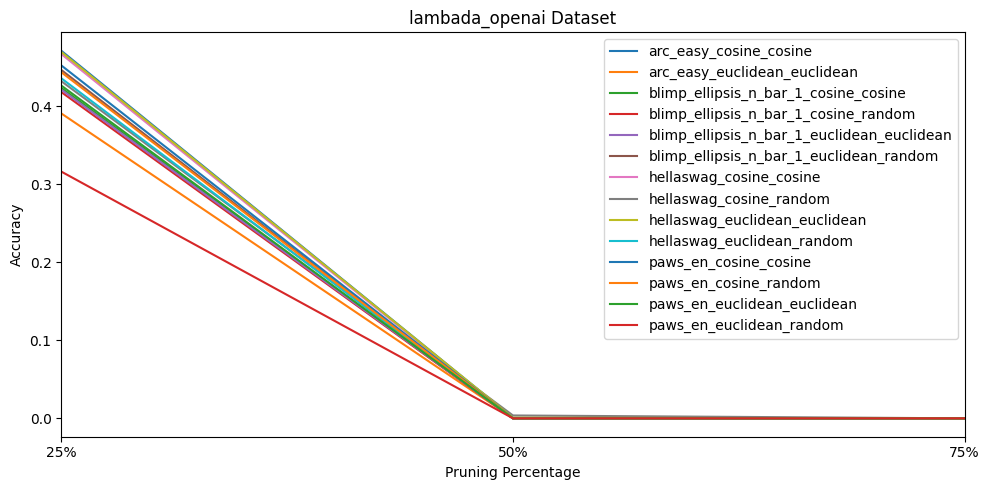

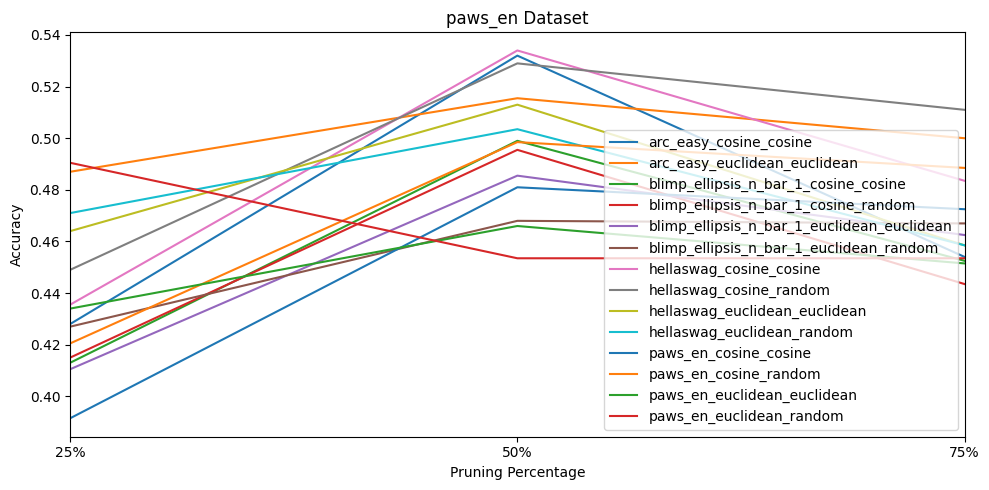

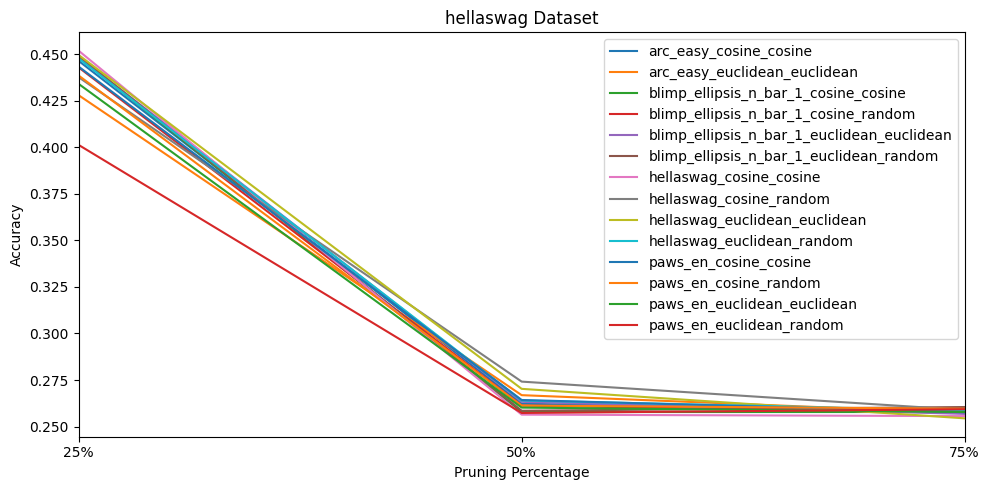

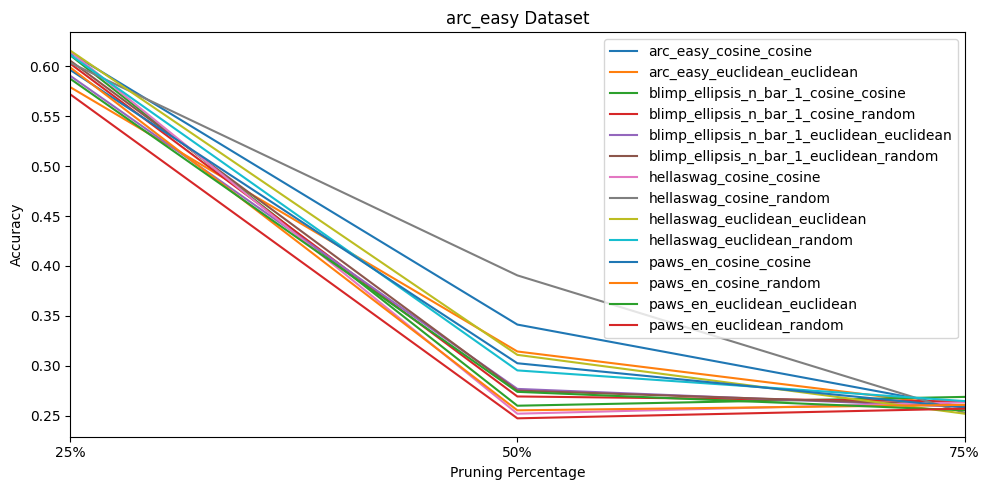

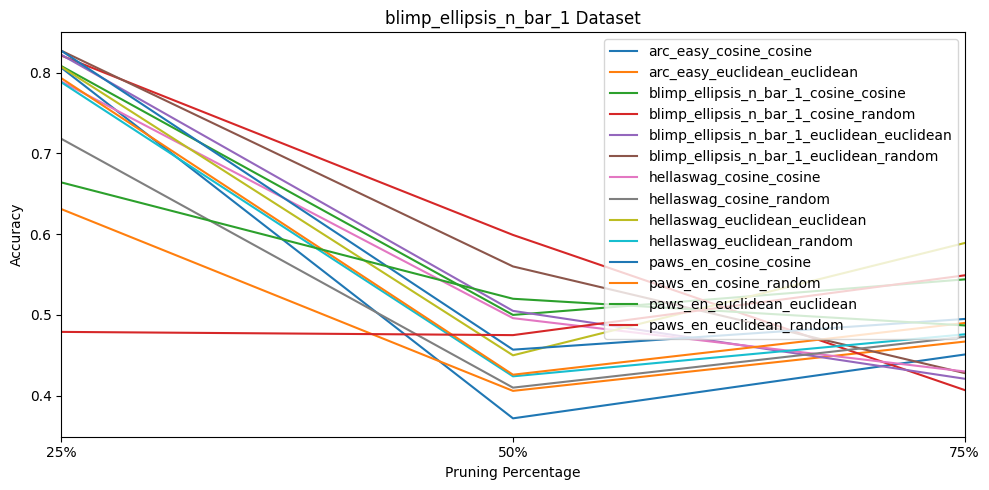

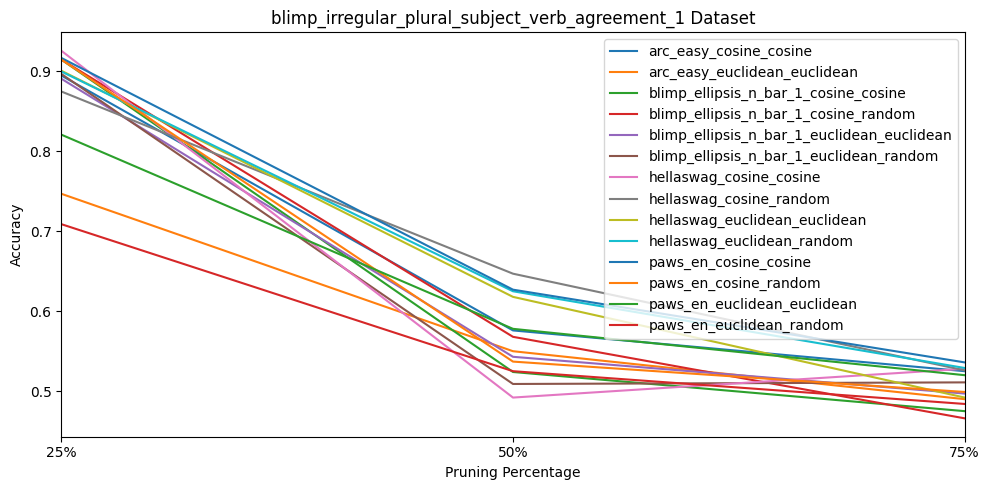

In [103]:
unique_tasks = df['task'].unique()

for task in unique_tasks:
    fig, ax = plt.subplots(figsize=(10, 5))

    task_data = df[df['task'] == task]
    for (prune_task, prune_metric), group_data in task_data.groupby(['prune_task', 'metric']):
        # Creating a unique label for each line
        label = f"{prune_task}_{prune_metric}"
        sorted_data = group_data.sort_values(by='percent')
        ax.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

    ax.set_title(f'{task} Dataset')
    ax.set_xlabel('Pruning Percentage')
    ax.set_ylabel('Accuracy')
    plt.xticks([0.25, 0.5, 0.75], ['25%', '50%', '75%'])
    # x axis between 0.25 and 0.75
    ax.set_xlim(0.25, 0.75)

    # Creating a legend
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

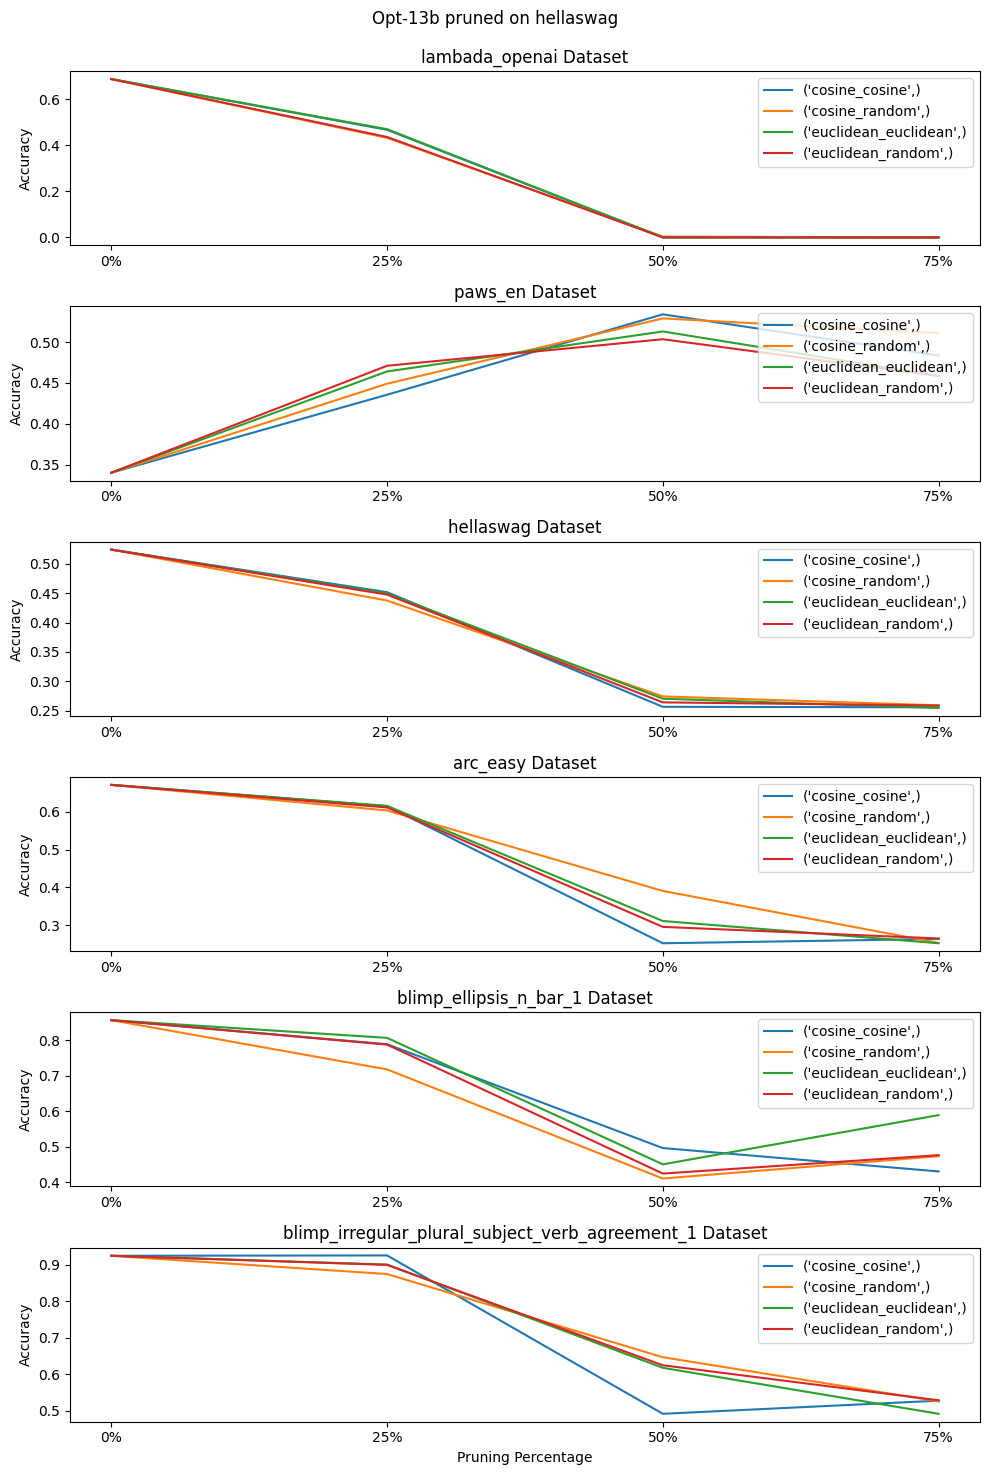

In [132]:
def prune_task_plots(selected_task = 'hellaswag', model='opt-13b'):
    unique_tasks = df['task'].unique()

    # Plotting
    fig, axes = plt.subplots(len(unique_tasks), 1, figsize=(10, 15))

    for i, task in enumerate(unique_tasks):
        hella = df[df['prune_task'] == selected_task]
        task_data = hella[hella['task'] == task]
        for prune_metric, group_data in task_data.groupby(['metric']):
            # Creating a unique label for each line
            label = prune_metric
            sorted_data = group_data.sort_values(by=['metric','percent'])
            axes[i].plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

        axes[i].set_title(f'{task} Dataset')
        axes[i].set_ylabel('Accuracy')
        axes[i].legend(loc='upper right')
        axes[i].set_xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])

    axes[-1].set_xlabel('Pruning Percentage')

    fig.suptitle(f'{model.capitalize()} pruned on {selected_task}\n')
    plt.tight_layout()
    plt.show()

prune_task_plots(selected_task='hellaswag', model='opt-13b')

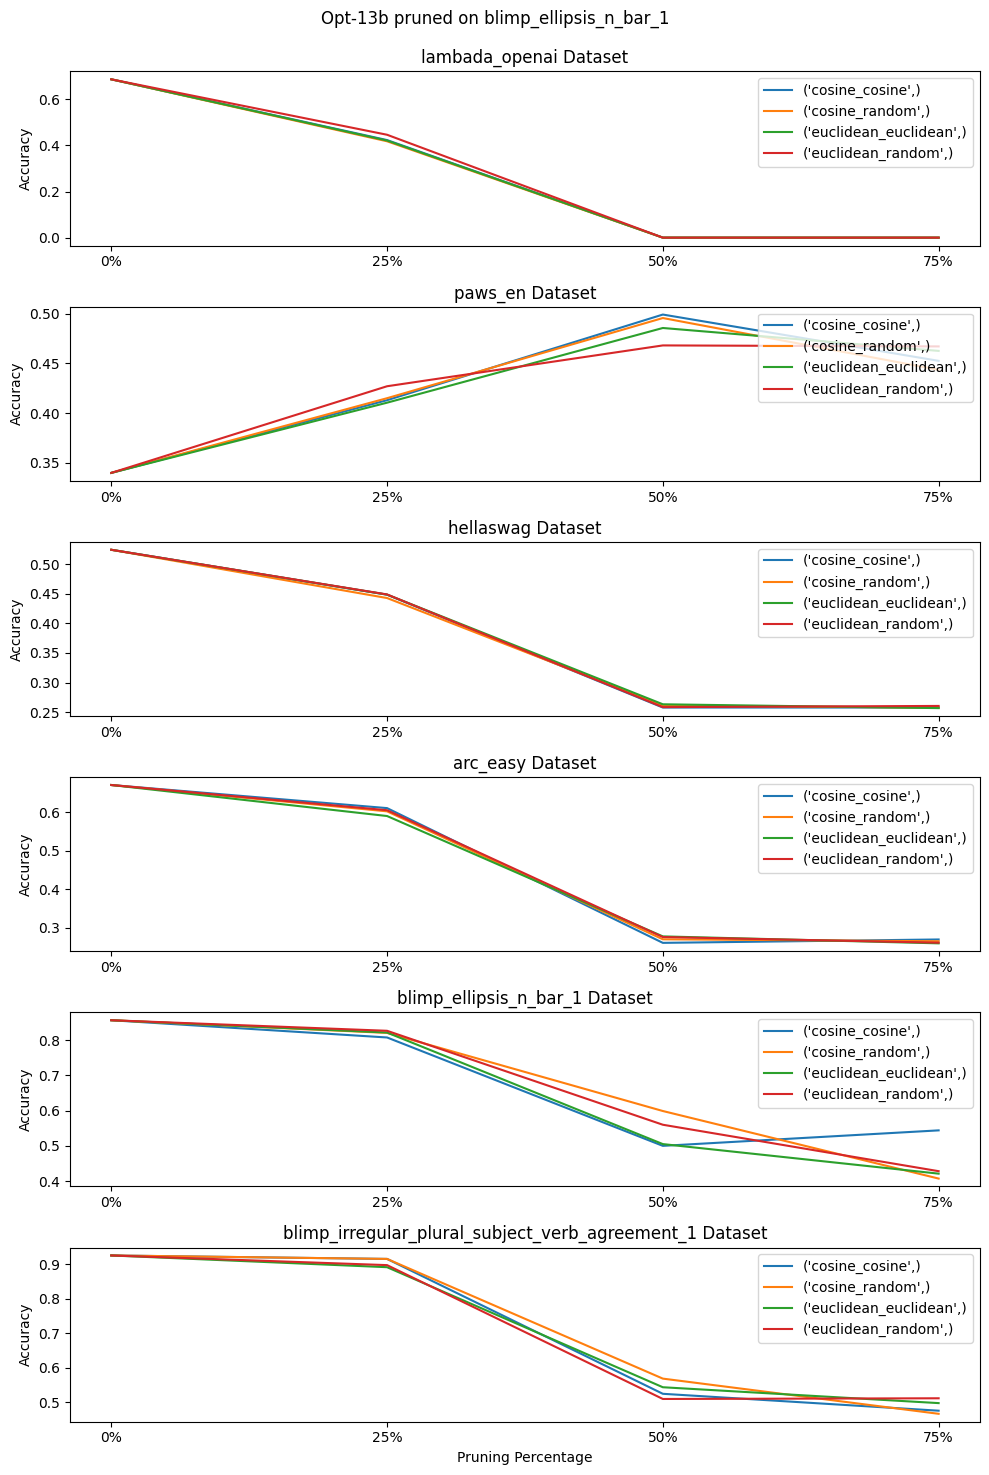

In [133]:
prune_task_plots(selected_task='blimp_ellipsis_n_bar_1', model='opt-13b')

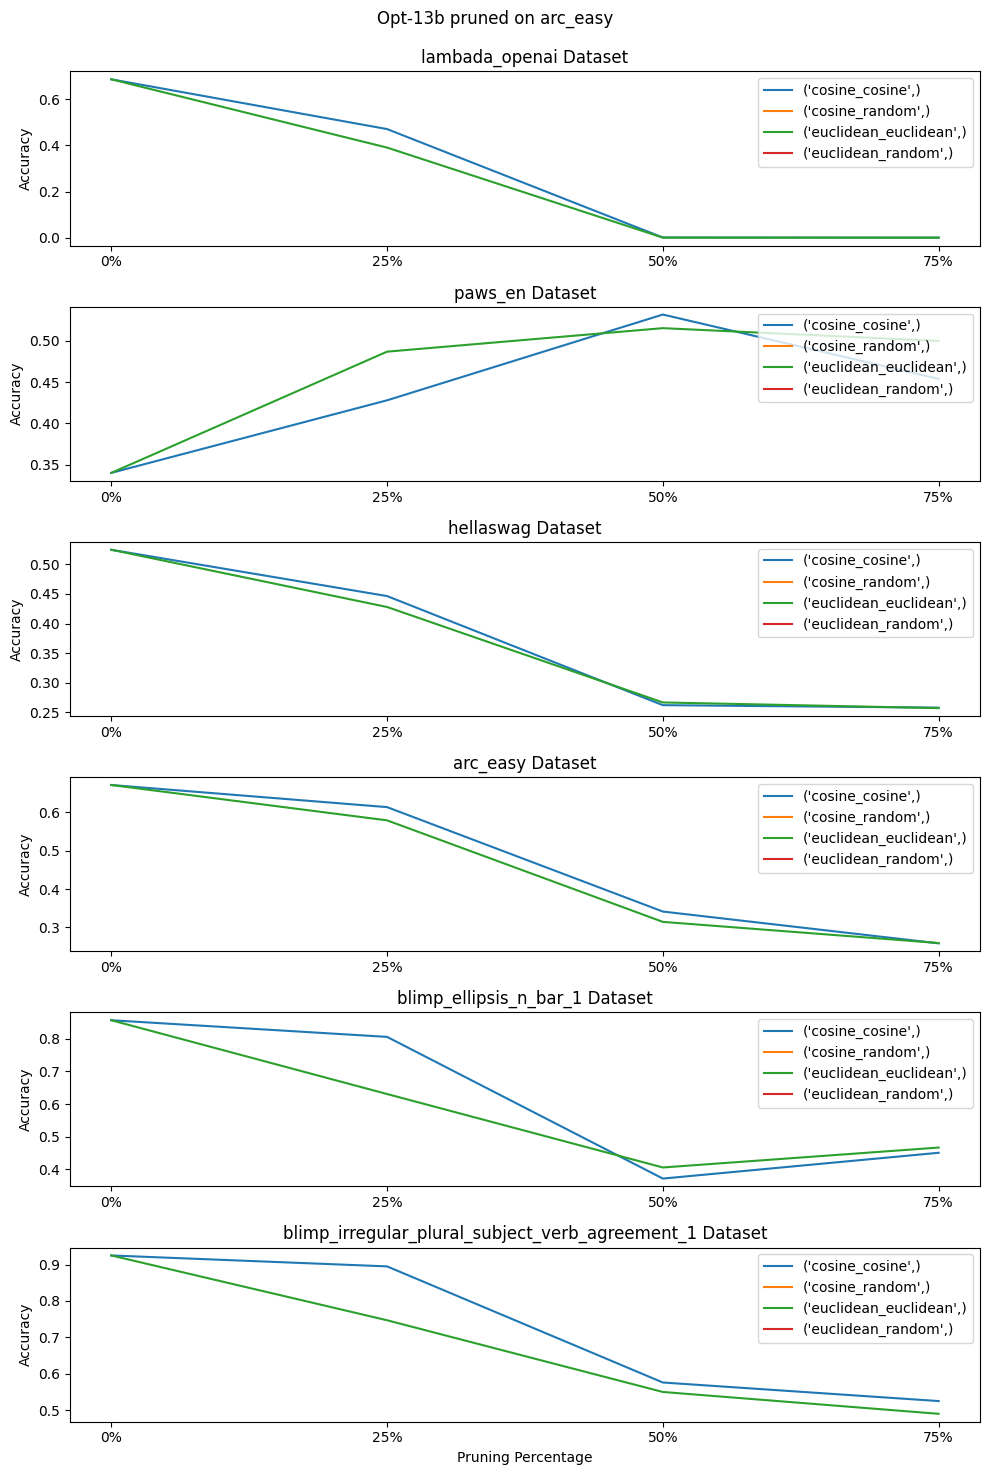

In [134]:
prune_task_plots(selected_task='arc_easy', model='opt-13b')

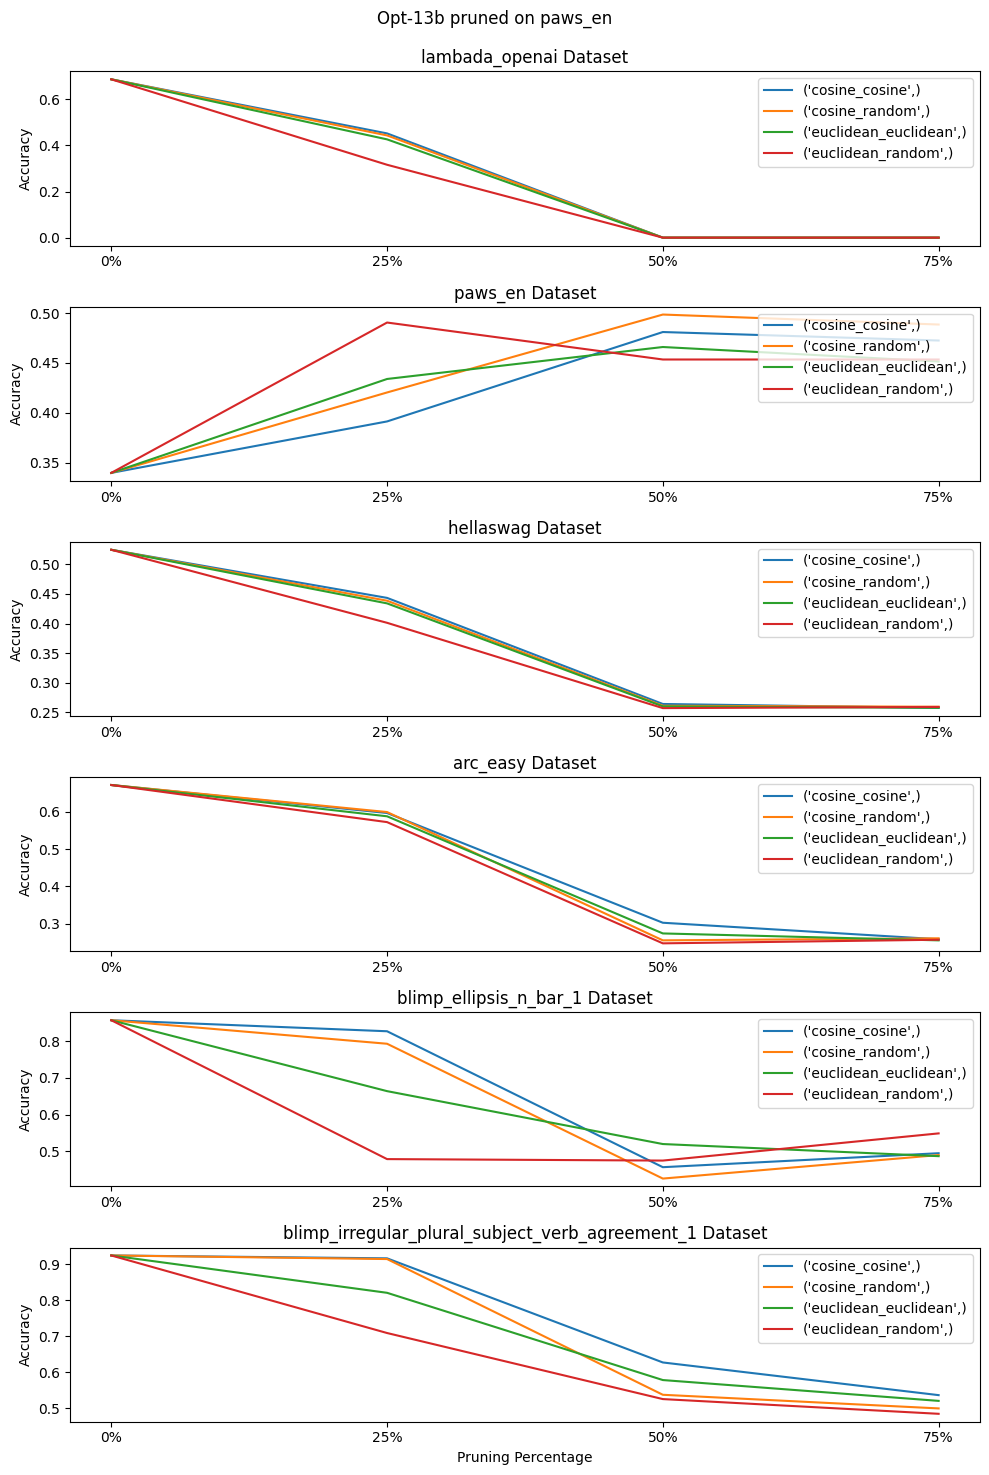

In [135]:
prune_task_plots(selected_task='paws_en', model='opt-13b')

In [ ]:
def between_task_plots(df, selected_task = 'hellaswag', model='opt-13b', prune_metric='cosine_cosine'):
    unique_tasks = df['task'].unique()
    df = df[df['metric'] == prune_metric]

    # Plotting
    fig, axes = plt.subplots(len(unique_tasks), 1, figsize=(10, 15))

    for i, task in enumerate(unique_tasks):
        hella = df[df['prune_task'] == selected_task]
        task_data = hella[hella['task'] == task]
        for prune_metric, group_data in task_data.groupby(['metric']):
            # Creating a unique label for each line
            label = prune_metric
            sorted_data = group_data.sort_values(by=['metric','percent'])
            axes[i].plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

        axes[i].set_title(f'{task} Dataset')
        axes[i].set_ylabel('Accuracy')
        axes[i].legend(loc='upper right')
        axes[i].set_xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])

    axes[-1].set_xlabel('Pruning Percentage')

    fig.suptitle(f'{model.capitalize()} pruned on {selected_task}\n')
    plt.tight_layout()
    plt.show()

prune_task_plots(selected_task='hellaswag', model='opt-13b')

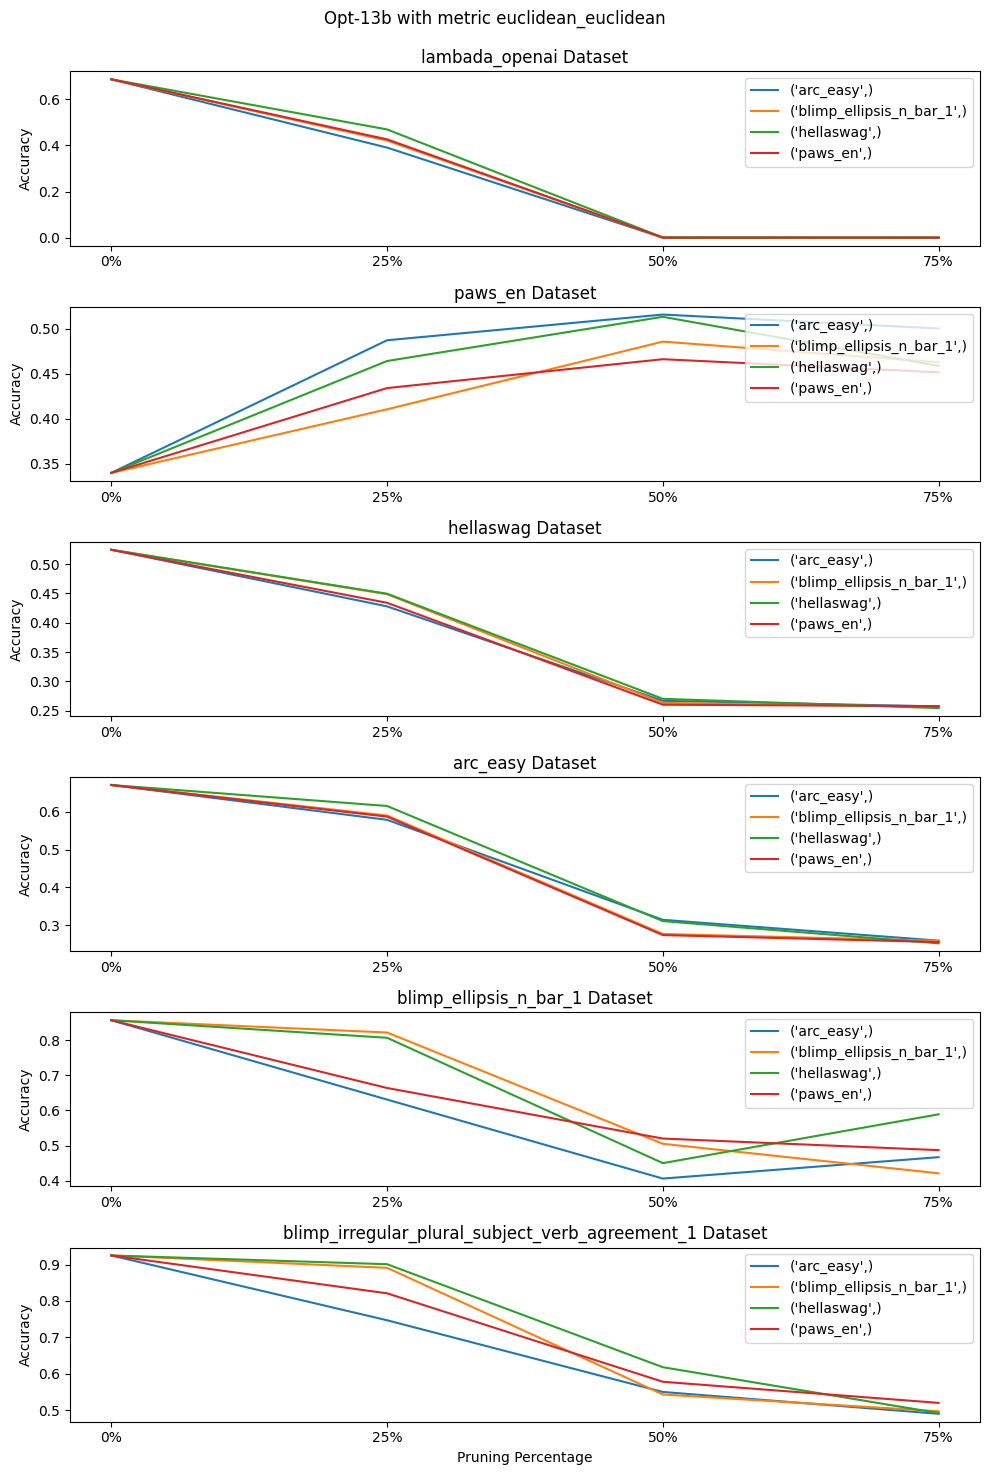

In [141]:
def metric_based_plot(df, prune_metric, model='opt-13b'):
    unique_tasks = df['task'].unique()

    # Plotting
    fig, axes = plt.subplots(len(unique_tasks), 1, figsize=(10, 15))

    for i, task in enumerate(unique_tasks):
        # Filtering the data based on the selected model and metric
        metric_data = df[(df['metric'] == prune_metric) & (df['model'] == model)]
        task_data = metric_data[metric_data['task'] == task]

        for prune_task, group_data in task_data.groupby(['prune_task']):
            # Creating a unique label for each line
            label = prune_task
            sorted_data = group_data.sort_values(by=['percent'])
            axes[i].plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

        axes[i].set_title(f'{task} Dataset')
        axes[i].set_ylabel('Accuracy')
        axes[i].legend(loc='upper right')
        axes[i].set_xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])

    axes[-1].set_xlabel('Pruning Percentage')
    fig.suptitle(f'{model.capitalize()} with metric {prune_metric}\n')
    plt.tight_layout()
    plt.show()

metric_based_plot(df, prune_metric='euclidean_euclidean', model='opt-13b')